# Capstone Project for Data Science Course 

This notebook will be mainly used for the Capstone Project of the Data Science Professional course from IBM on Coursera

In [642]:
import pandas as pd
import numpy as np
import json

from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

from sklearn.cluster import KMeans
!pip install folium
import folium 

import requests

import types
from botocore.client import Config
import ibm_boto3

from sklearn import linear_model

print('Libraries imported.')

Libraries imported.


In [3]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


## Perfect arrondissement for a japanese restaurant in Paris?

### Business Case
The recent COVID-19 pandemic has a major impact on the food service industry, leading to many restaurants going out of business.
But eventually the economy will recover, and the freshly vacated locations in major cities, give opportunities for new businesses. 

Japanese cuisine has been rapidly gaining popularity in the last decades and usually generates high revenue in the premium segment. 
The city of Paris is famous for its fancy restaurants and indicates that the general population or the visiting customers, have a
appreciation for premium food and also the willingness to pay premium.

Given the prequisites, that the distance to the sea and a subsequent quality fish-market is not a deciding factor, but solely the georgraphic location, 
a recommendation shall be derived for a japanese restaurant within the 20 districts of Paris. 

### Data 
In order to derive recommendations, it is necessary to get information regarding the possible locations (the 20 districts):
- The french public service provides the name, popoulation, and area of the arrondissements (districts) of Paris which is also available on wikipedia: https://en.wikipedia.org/wiki/Arrondissements_of_Paris
- FourSquare provides information regarding the venues in the location of interest, such as restaurants and ratings of the restaurants. Relevant data:
    - Trending Venue Data to rate the location regarding future prospect
    - Similar Venues to avoid possible competition
    - General venue stats
    - Venue Type 
- GeoData from the public database

#### Data Collection
Lets start with collecting the data and converting it into a useable format (a panda dataframe with the correct datatypes)

##### Paris data on arrondissements
Pandas web scraping tool shall be used to get the data table from the Wikipedia Page

In [786]:
paris_df = pd.read_html("https://en.wikipedia.org/wiki/Arrondissements_of_Paris")
paris_df = paris_df[2]
paris_df.head()

,"Arrondissement (R for Right Bank, L for Left Bank)",Name,Area (km2),Population(2017 estimate),Density (2017)(inhabitants per km2),Peak of population,Mayor,2020-2026
0,Paris Centre 1st (Ier) / 2nd (IIe) / 3rd (IIIe...,"Louvre, Bourse, Temple, Hôtel-de-Ville",5.59 km2 (2.16 sq mi),100196,17924,before 1861,Ariel Weil (PS),NaN
1,5th (Ve) L,Panthéon,2.541 km2 (0.981 sq mi),59631,23477,1911,Florence Berthout (DVD),NaN
2,6th (VIe) L,Luxembourg,2.154 km2 (0.832 sq mi),41976,19524,1911,Jean-Pierre Lecoq (LR),NaN
3,7th (VIIe) L,Palais-Bourbon,4.088 km2 (1.578 sq mi),52193,12761,1926,Rachida Dati (LR),NaN
4,8th (VIIIe) R,Élysée,3.881 km2 (1.498 sq mi),37368,9631,1891,Jeanne d'Hauteserre (LR),NaN


This table provides a rough overview of the paris arrondissements, but we will need to do some cleaning up:
- Remove Informations regarding the majors
- Rename the columns for better addressing
- Convert Area data into floats
- Set datatypes for population and density to int (if not already)
- Split the first row into its individual arrondissements with equal size

In [787]:
paris_df = paris_df[["Arrondissement (R for Right Bank, L for Left Bank)","Name","Area (km2)", "Population(2017 estimate)","Density (2017)(inhabitants per km2)"]]
paris_df.columns=["District","Name","Area", "Population","Density"]
paris_df.head()

,District,Name,Area,Population,Density
0,Paris Centre 1st (Ier) / 2nd (IIe) / 3rd (IIIe...,"Louvre, Bourse, Temple, Hôtel-de-Ville",5.59 km2 (2.16 sq mi),100196,17924
1,5th (Ve) L,Panthéon,2.541 km2 (0.981 sq mi),59631,23477
2,6th (VIe) L,Luxembourg,2.154 km2 (0.832 sq mi),41976,19524
3,7th (VIIe) L,Palais-Bourbon,4.088 km2 (1.578 sq mi),52193,12761
4,8th (VIIIe) R,Élysée,3.881 km2 (1.498 sq mi),37368,9631


In [788]:
areas_km =[]
for i in paris_df.index:
    areas_km.append(float(paris_df["Area"][i][0:paris_df["Area"][0].find("k")]))
paris_df[["Area"]] = areas_km
paris_df

,District,Name,Area,Population,Density
0,Paris Centre 1st (Ier) / 2nd (IIe) / 3rd (IIIe...,"Louvre, Bourse, Temple, Hôtel-de-Ville",5.590,100196,17924
1,5th (Ve) L,Panthéon,2.541,59631,23477
2,6th (VIe) L,Luxembourg,2.154,41976,19524
3,7th (VIIe) L,Palais-Bourbon,4.088,52193,12761
4,8th (VIIIe) R,Élysée,3.881,37368,9631
5,9th (IXe) R,Opéra,2.179,60071,27556
6,10th (Xe) R,Entrepôt,2.892,90836,31431
7,11th (XIe) R,Popincourt,3.666,147470,40183
8,12th (XIIe) R,Reuilly,16.320,141287,"8,657¹21,729²"
9,13th (XIIIe) L,Gobelins,7.146,183399,25650


In [789]:
# Density includes some footnotes which are difficult to remove 
# re-calculate it with population and area size
density_calc = []
for i in paris_df.index:
    density_calc.append(int(paris_df.loc[i]["Population"]/paris_df.loc[i]["Area"]))
paris_df["Density"] = density_calc

In [790]:
# Split Paris Centre into its individual districts
paris_center_districts = paris_df["District"][0].split("/")
paris_center_names = paris_df["Name"][0].split(",")
paris_center_area = paris_df["Area"][0]/len(paris_center_districts )
test_df = pd.DataFrame(columns=["District", "Name", "Area", "Population", "Density"])
for i in range(len(paris_center_districts)):
    print(paris_center_districts[i])
    paris_df = paris_df.append({"District":paris_center_districts[i],
                                    "Name":paris_center_names[i],
                                    "Area":paris_df["Area"][0]/len(paris_center_districts ),
                                    "Population":paris_df["Population"][0]/len(paris_center_districts ),
                                    "Density":paris_df["Density"][0]/len(paris_center_districts )}, ignore_index=True)
paris_df.drop([0], axis = 0, inplace=True)
paris_df

Paris Centre 1st (Ier) 
 2nd (IIe) 
 3rd (IIIe) 
 4th (IVe) R


,District,Name,Area,Population,Density
1,5th (Ve) L,Panthéon,2.5410,59631.0,23467.0
2,6th (VIe) L,Luxembourg,2.1540,41976.0,19487.0
3,7th (VIIe) L,Palais-Bourbon,4.0880,52193.0,12767.0
4,8th (VIIIe) R,Élysée,3.8810,37368.0,9628.0
5,9th (IXe) R,Opéra,2.1790,60071.0,27568.0
6,10th (Xe) R,Entrepôt,2.8920,90836.0,31409.0
7,11th (XIe) R,Popincourt,3.6660,147470.0,40226.0
8,12th (XIIe) R,Reuilly,16.3200,141287.0,8657.0
9,13th (XIIIe) L,Gobelins,7.1460,183399.0,25664.0
10,14th (XIVe) L,Observatoire,5.6210,136941.0,24362.0


#### Venue information in each arrondissement (District)
Now we have a complete overview of all the arrondissements in paris in a comprehensive data format. We can proceed with acquiring the relevant venue data from foursquare.

In the first step, lets extract all the relevant data

In [329]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: WVDLAWQSPRWK1OE3NFXKNGWFOVMNXK51RIIVHOIMAVC5RPSA
CLIENT_SECRET:JHWV2B2EJD0VMS3JK4GZNEL0RUUQ10WXMFTBS2AIUUF0G1PZ


#### Write a function to receive the following information from foursquare
- Retreive the food-venues with a price rating of 3 or 4 (>20USD) as we are targeting the premium segment
- The food-venues shall be sorted by popularity

In [320]:
def getPremiumRestaurants(address, radius,name):
    restaurant_list=[]
    print(address)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&price={}&sortByPopularity={}&section={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT,
        "3,4",
        1,
        "food"
        )

    # make the GET request
    results = requests.get(url).json()
    if results["response"] != []:
        results = results["response"]['groups'][0]['items']
    else:
        return []
    restaurant_list.append([(
    name, 
    latitude, 
    longitude, 
    v['venue']['name'], 
    v['venue']['location']['lat'], 
    v['venue']['location']['lng'],  
    v['venue']['categories'][0]['name']) for v in results])

    district_restaurants = pd.DataFrame([item for restaurant_list in restaurant_list for item in restaurant_list])
    district_restaurants.columns = ['District', 
              'District Latitude', 
              'District Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
    return( district_restaurants)
    

##### Problem
Since it is not possible to pass the district borders to foursquare, we will calculate the radius of the district area under assumption of a circle

In [795]:
column_names = ['District', 
              'District Latitude', 
              'District Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
venues_paris_df = pd.DataFrame(columns = column_names)

for i in paris_df.index:
    address = "Paris, "+paris_df.loc[i]["Name"]
    name = paris_df.loc[i]["Name"]
    radius = 1000*np.sqrt((paris_df.loc[i]["Area"]/np.pi))
    add_venues = getPremiumRestaurants(address, radius,name)
    venues_paris_df = venues_paris_df.append(add_venues)
venues_paris_df.head()

Paris, Panthéon
Paris, Luxembourg
Paris, Palais-Bourbon
Paris, Élysée
Paris, Opéra
Paris, Entrepôt
Paris, Popincourt
Paris, Reuilly
Paris, Gobelins
Paris, Observatoire
Paris, Vaugirard
Paris, Passy
Paris, Batignolles-Monceau
Paris, Buttes-Montmartre
Paris, Buttes-Chaumont
Paris, Ménilmontant
Paris, Louvre
Paris,  Bourse
Paris,  Temple
Paris,  Hôtel-de-Ville


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Panthéon,48.846191,2.346079,Les Belles Plantes,48.844616,2.356903,French Restaurant
1,Panthéon,48.846191,2.346079,La Tour d'Argent,48.849791,2.354950,French Restaurant
2,Panthéon,48.846191,2.346079,Les Papilles,48.844630,2.341900,Bistro
3,Panthéon,48.846191,2.346079,Sourire Tapas Françaises,48.851167,2.347728,Tapas Restaurant
4,Panthéon,48.846191,2.346079,13 au Jardin,48.848587,2.339511,New American Restaurant


In [796]:
venues_paris_df.shape

(1028, 7)

Lets extract all the venues which could be competitive towards a japanese restaurant:
- Existing japanese restaurants
- Existing asian restaurants as they may also serve japanese food
- Existing seafood restaurants as they serve similar food

In [797]:
japanese_venues = venues_paris_df[venues_paris_df["Venue Category"].str.contains("Ja")]
asian_venues = venues_paris_df[venues_paris_df["Venue Category"].str.contains("Asi")]
fish_venues =  venues_paris_df[venues_paris_df["Venue Category"].str.contains("Sea")]
fish_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
12,Panthéon,48.846191,2.346079,L'Avant Comptoir de la Mer,48.852179,2.338600,Seafood Restaurant
16,Panthéon,48.846191,2.346079,Le Bar à Huîtres,48.850993,2.345795,Seafood Restaurant
18,Panthéon,48.846191,2.346079,La Méditerranée,48.849900,2.338717,Seafood Restaurant
32,Panthéon,48.846191,2.346079,Bar à Iode,48.849600,2.351608,Seafood Restaurant
7,Luxembourg,48.850433,2.332951,Huguette,48.853275,2.337111,Seafood Restaurant


#### Visualize the data
Now we have the information regarding the premium-segment venues in Paris in each district. Lets have a look at the data in folium and mark each venue.
Grey = Other premium segment restaurant
Orange = Other Seafood restaurant
Red = Other Asian restaurant
Darkred = Other japanese restaurant

In [798]:
paris_latitude =48.864716
paris_longitude = 2.349014
map_paris= folium.Map(location=[paris_latitude, paris_longitude], width='50%', height='50%', zoom_start=12)
markers_colors = []
for lat, lon, poi, cat in zip(venues_paris_df['Venue Latitude'], venues_paris_df['Venue Longitude'], venues_paris_df['District'], venues_paris_df['Venue Category']):
    label = folium.Popup(cat, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        fill=True,
        color ="gray",
        fill_opacity=0.1).add_to(map_paris)
    
# Add the Asian Restaurants in a different color

for lat, lon, poi, cat in zip(asian_venues['Venue Latitude'], asian_venues['Venue Longitude'], asian_venues['District'], asian_venues['Venue Category']):
    label = folium.Popup(cat, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        fill=True,
        color = "red",
        fill_opacity=0.7).add_to(map_paris)
    
# Add the Seafood Restaurants in a different color

for lat, lon, poi, cat in zip(fish_venues['Venue Latitude'], fish_venues['Venue Longitude'], fish_venues['District'], fish_venues['Venue Category']):
    label = folium.Popup(cat, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        fill=True,
        color="orange",
        fill_opacity=0.7).add_to(map_paris)

# Add the Japanese Restaurants in a different color
for lat, lon, poi, cat in zip(japanese_venues['Venue Latitude'], japanese_venues['Venue Longitude'],japanese_venues['District'], japanese_venues['Venue Category']):
    label = folium.Popup(cat, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color = "darkred",
        fill=True,
        fill_opacity=0.7).add_to(map_paris)
map_paris

It can be observed that there are not many japanese restaurants in the premium segment available in Paris. 
Lets try to visualize the various venues in a bar chart.

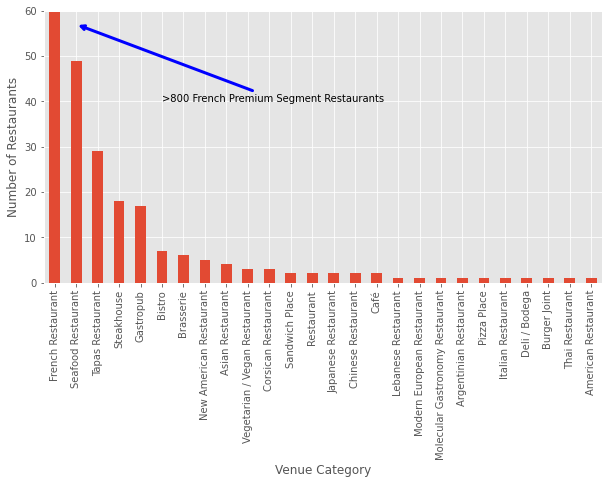

In [799]:
venues_sorted = venues_paris_df.groupby("Venue Category").count().sort_values("District", ascending = False)["District"]
venues_sorted.plot(kind="bar", figsize = (10,5), ylim=(0,60))
plt.ylabel("Number of Restaurants")
plt.annotate('>800 French Premium Segment Restaurants',                      # s: str. Will leave it blank for no text
             xy=(1, 57),             # place head of the arrow at point (year 2012 , pop 70)
             xytext=(5, 40),         # place base of the arrow at point (year 2008 , pop 20)
             xycoords='data',         # will use the coordinate system of the object being annotated 
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=3)
            )

plt.show()

#### Methodology
Now that we know the data, we need to derive an appropriate metric to derive recommendations for each district
The metrics shall be
- Population Density
- Restaurant Density (independent of type)
- Relevant Restaurant Density (asian, seafood, japanese)

In [800]:
## group the relevant restaurants
japanese_venues=pd.DataFrame(japanese_venues.groupby("District")["Venue"].count())
asian_venues=pd.DataFrame(asian_venues.groupby("District")["Venue"].count())
fish_venues=pd.DataFrame(fish_venues.groupby("District")["Venue"].count())

In [801]:
venue_count = pd.DataFrame(venues_paris_df.groupby("District")["Venue"].count())

rest_dens = []
rel_rest_dens = []
for i in paris_df.index:
    rest_dens.append(float(venue_count.loc[venue_count.index==paris_df.loc[i]["Name"]]["Venue"])/paris_df.loc[i]["Area"])
    jp_count = japanese_venues.loc[japanese_venues.index==paris_df.loc[i]["Name"]]["Venue"]
    if jp_count.size == 0:
        jp_count = 0
    else:
        jp_count = jp_count.values
    asian_count =  asian_venues.loc[asian_venues.index==paris_df.loc[i]["Name"]]["Venue"]
    if asian_count.size ==0:
        asian_count = 0
    else:
        asian_count = asian_count.values
    fish_count =  fish_venues.loc[fish_venues.index==paris_df.loc[i]["Name"]]["Venue"]
    if fish_count.size == 0:
        fish_count = 0
    else:
        fish_count = fish_count.values
    relcount = fish_count+jp_count+asian_count
    rel_rest_dens.append(float(relcount/paris_df.loc[i]["Area"]))
   # print(venue_count.loc[venue_count.index==paris_df.loc[i]["Name"]]["Venue"])
    
    #paris_df.loc[paris_df[paris_df["Name"]==i].index]["Restaurant_density"] =venue_count.loc[i]["Venue"]/float(paris_df[paris_df["Name"]==i]["Area"])
paris_df["Restaurant_density"] = rest_dens
paris_df["Rel_Restaurant_density"] = rel_rest_dens

paris_df.head()

,District,Name,Area,Population,Density,Restaurant_density,Rel_Restaurant_density
1,5th (Ve) L,Panthéon,2.541,59631.0,23467.0,15.741834,1.574183
2,6th (VIe) L,Luxembourg,2.154,41976.0,19487.0,20.427112,2.785515
3,7th (VIIe) L,Palais-Bourbon,4.088,52193.0,12767.0,24.461840,0.978474
4,8th (VIIIe) R,Élysée,3.881,37368.0,9628.0,15.975264,1.288328
5,9th (IXe) R,Opéra,2.179,60071.0,27568.0,32.583754,0.917852


Lets have a look how restaurant density correlates to population density

In [802]:
regr = linear_model.LinearRegression()
y_data = np.asanyarray(paris_df[["Restaurant_density"]])
x_data = np.asanyarray(paris_df[["Density"]])
regr.fit(x_data, y_data)

LinearRegression()

Text(0, 0.5, 'Luxury Restaurant Density')

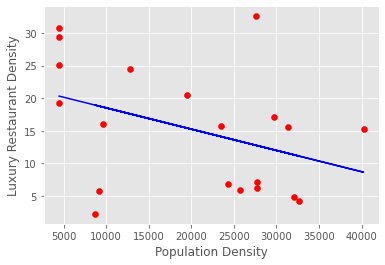

In [803]:
plt.scatter(paris_df.Density,paris_df.Restaurant_density, color="red")
plt.plot(x_data, regr.coef_[0][0]*x_data + regr.intercept_[0], '-b')
plt.xlabel("Population Density")
plt.ylabel("Luxury Restaurant Density")

One would assume, that there is a positive correlation between the population density and the (luxury) restaurant density.
Interestingly it can be observed that the restaurant density does not correlate with the population density. 

### Result
The derived restaurant density for relevant and regular restaurants shall be displayed in a heatmap.

Lets first import a geojson file for paris available on Github
https://github.com/codeforamerica/click_that_hood/blob/master/public/data/paris.geojson

In [804]:
!wget --quiet https://www.data.gouv.fr/en/datasets/r/4765fe48-35fd-4536-b029-4727380ce23c
print("GeoJson file downloaded")

GeoJson file downloaded


In [805]:
paris_geo = r'4765fe48-35fd-4536-b029-4727380ce23c'
world_geo = r'paris.geojson'
#world_geo = r'san-francisco.geojson' # geojson file

In [809]:
# The names in the paris_df dataframe do not exactly 

#correct buttes-montmartre, Bourse, temple , hotel-de-ville,... so it matches the GeoJSON Data
paris_df["Name"].replace({"Butte-Montmartre":"Buttes-Montmartre"}, inplace = True)
paris_df["Name"].replace({" Hôtel-de-Ville":"Hôtel-de-Ville"}, inplace = True)
paris_df["Name"].replace({" Temple":"Temple"}, inplace = True)
paris_df["Name"].replace({" Bourse":"Bourse"}, inplace = True)

paris_df.head()

,District,Name,Area,Population,Density,Restaurant_density,Rel_Restaurant_density
1,5th (Ve) L,Panthéon,2.541,59631.0,23467.0,15.741834,1.574183
2,6th (VIe) L,Luxembourg,2.154,41976.0,19487.0,20.427112,2.785515
3,7th (VIIe) L,Palais-Bourbon,4.088,52193.0,12767.0,24.461840,0.978474
4,8th (VIIIe) R,Élysée,3.881,37368.0,9628.0,15.975264,1.288328
5,9th (IXe) R,Opéra,2.179,60071.0,27568.0,32.583754,0.917852


In [808]:
paris_map = folium.Map(location = [paris_latitude ,paris_longitude], width='50%', height='50%', zoom_start=11)
paris_map.choropleth(geo_data = paris_geo,
                                        data = paris_df,
                                        columns=["Name","Restaurant_density"],
                                        key_on='feature.properties.l_aroff',
                                        fill_color='YlOrRd', 
                                        fill_opacity=0.7, 
                                        line_opacity=0.2,
                                        legend_name='Restaurant density in Paris in Restaurants/km2'
                    )
paris_map


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
